In [6]:
import itertools
import os

import jax.numpy as jnp
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from softcvi_validation.tasks.available_tasks import get_available_tasks
from softcvi_validation.utils import get_palette

from spyrox.utils import get_abspath_project_root

os.chdir(get_abspath_project_root())
plt.style.use('./plots/style.mplstyle')
palette = get_palette()
palette.pop("SoftCVI(a=0)")

tasks = get_available_tasks()
method_names = [k for k in palette.keys() if k!="True"]

box_kwargs = {
    "showfliers": False,
    "palette": palette,
    "saturation": 1,
    "linewidth": 0.6,
}

num_rounds = [1, 2, 4]
seeds = range(1,201)
budget=20000

handles = [
    mpatches.Patch(facecolor=v, label=k.replace("a=", r"$\alpha$="), edgecolor="black")
    for k, v in palette.items() if k in method_names
]

In [7]:
log_prob_true_data = {
    "method_name": [],
    "log_prob_true": [],
    "num_rounds": [],
    "seed": [],
}

coverage_data = {
    "method_name": [],
    "coverage_prob": [],
    "num_rounds": [],
}


coverage_results = {
    method_name: {} for method_name in method_names 
}

for n_rounds, seed, method in itertools.product(num_rounds, seeds, method_names):

    cov_probs = []
    
    file = f"results/metrics/{method}_seed={seed}_num_rounds={n_rounds}_budget={budget}.npz"

    try:    
        metrics = dict(np.load(file))
    except FileNotFoundError:
        print(f"Not found: {file}")
        continue
     
    log_prob_true_data["method_name"].append(method)
    log_prob_true_data["log_prob_true"].append(metrics["log_prob_true"].item())
    log_prob_true_data["num_rounds"].append(n_rounds)
    log_prob_true_data["seed"].append(seed)

    coverage_data["method_name"].append(method)
    coverage_data["coverage_prob"].append(metrics["coverage_prob"].item())
    coverage_data["num_rounds"].append(n_rounds)


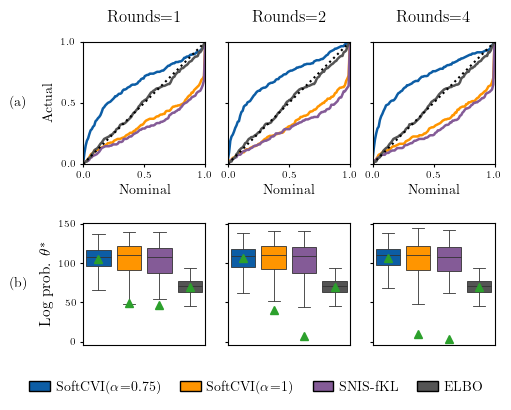

In [ ]:
coverage_df = pd.DataFrame(coverage_data)

total_fig = plt.figure(constrained_layout=True, figsize=(5, 4))
fig, legend_fig = total_fig.subfigures(nrows=2, height_ratios=[10, 1])

cov_axes, log_prob_axes = fig.subplots(
    ncols=len(num_rounds),
    nrows=2,
    sharey="row",    
)

for r, ax in zip(num_rounds, cov_axes, strict=True):
    for method in method_names:
        probs = jnp.asarray(
            coverage_df[
                (coverage_df["num_rounds"] == r) & (coverage_df["method_name"] == method)
            ]["coverage_prob"],
        )

        nominal = jnp.linspace(0, 1, 100)
        coverage_freq = jnp.array([(probs >= 1 - nom).mean() for nom in nominal])

        ax.plot(
            nominal,
            coverage_freq,
            label=method,
            color=palette[method],
            linewidth=1.8,
            )

    ax.plot(nominal, nominal, linestyle=":", color="black")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"Rounds={r}", y=1.1, size=12)

cov_axes[0].set_ylabel("Actual")
[ax.set_xlabel("Nominal") for ax in cov_axes]
[ax.set_box_aspect(1) for ax in cov_axes]

df = pd.DataFrame(log_prob_true_data)

for ax, n_rounds in zip(log_prob_axes, num_rounds, strict=True):
    sns.boxplot(
        data=df[df["num_rounds"] == n_rounds],
        x="method_name",
        y="log_prob_true",
        hue="method_name",
        hue_order=palette.keys(),
        ax=ax,
        legend=False,
        showmeans=True,
        **box_kwargs,
    )

log_prob_axes[0].set_ylabel(r"Log prob. $\mathbb{\theta}^*$", size=11)
legend_fig.legend(handles=handles, ncols=len(method_names))

for ax in log_prob_axes:
    ax.set_box_aspect(1)
    ax.set_xlabel("")
    ax.set_xticks([])

for ax in cov_axes:
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])


for letter, ax in zip(["a", "b"], (cov_axes[0], log_prob_axes[0]), strict=True):
    ax.text(-0.6, 0.5, f"({letter})", transform=ax.transAxes, va='center')

total_fig.savefig(f"plots/sirsde_with_covariates_metrics.pdf")

In [10]:
import pandas as pd
from scipy.stats import ttest_rel

df_subset = df[df["method_name"]=="SoftCVI(a=0.75)"].drop(columns="method_name") # .groupby("num_rounds")  .mean(numeric_only=True)
data = df_subset.sort_values(by=['seed', 'num_rounds'])

for rounds in [2, 4]:
    test = ttest_rel(
        data[data["num_rounds"] == rounds]["log_prob_true"],
        data[data["num_rounds"] == 1]["log_prob_true"],
        )
    print(f"round: {rounds}, t-test value: {test.pvalue}")

for rounds in [1,2,4]:
    lps = data[data["num_rounds"] == rounds]["log_prob_true"]
    print(f"Rounds {rounds} Mean LP: {lps.mean()} Median LP: {np.median(lps)}")



round: 2, t-test value: 0.14389894806781658
round: 4, t-test value: 0.00882850143216286
Rounds 1 Mean LP: 105.15335893630981 Median LP: 107.5147476196289
Rounds 2 Mean LP: 106.28934644699096 Median LP: 109.61511611938477
Rounds 4 Mean LP: 106.87298740386963 Median LP: 109.77404022216797


In [11]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.typing import ArrayLike

def pairplot_dictionary(
    fig,
    data: dict[str, ArrayLike],
    truth: ArrayLike,
    *,
    column_names: list[str],
    palette=None,
    s: float = 10,
):
    """Generate a pairplot from a dictionary of arrays.

    Args:
        data: Dictionary of 2D arrays.
        truth: 1D array of true values.
        column_names: Column names corresponding to array columns.
        filter_outliers: Filter outliers outside the interval
            ``[Q1–filter_outliers*IQR, Q3+filter_outliers*IQR]``. Defaults to 3.
        s: The point size.
    """
    num_cols = len(column_names)
    
    data = _filter_outliers(data)    
    axes = fig.subplots(num_cols, num_cols)

    for i, col1 in enumerate(column_names):
        for j, col2 in enumerate(column_names):
            ax = axes[i, j]

            if j > i:
                ax.axis("off")
                continue

            if i == j:
                # Diagonal: density plot
                for source, d in data.items():
                    values = d[:, i]
                    sns.kdeplot(
                        data=values,
                        ax=ax,
                        color=palette[source],
                        fill=palette[source],
                        alpha=0.3,
                        )
                ax.yaxis.set_visible(False)
                ax.axvline(truth[i], color="tab:green")
            else:
                # Off-diagonal: scatter plot
                for source, d in data.items():
                    ax.scatter(
                        d[:, j],
                        d[:, i],
                        label=source,
                        s=s,
                        alpha=0.8,
                        color=palette[source],
                        rasterized=True,
                    )
                    ax.scatter(
                        truth[j],
                        truth[i],
                        label="True",
                        s=10*s,
                        color="tab:green",
                        rasterized=True,
                    )

            if i == num_cols - 1:
                ax.set_xlabel(col2)
            else: 
                ax.xaxis.set_visible(False)
            if j == 0:
                ax.set_ylabel(col1)
            if j!=0:
                ax.yaxis.set_visible(False)

    [ax.set_box_aspect(1) for ax in axes.ravel()]
    return fig, axes

def _filter_outliers(data, n=3):
    for k, arr in data.items():
        q1 = jnp.nanpercentile(arr, 25, axis=0)
        q3 = jnp.nanpercentile(arr, 75, axis=0)
        iqr = q3 - q1
        lower_bound = q1 - n * iqr
        upper_bound = q3 + n * iqr
        mask = jnp.logical_and(arr >= lower_bound, arr <= upper_bound).all(axis=1)
        data[k] = arr[mask]

    return data



## Example run fig

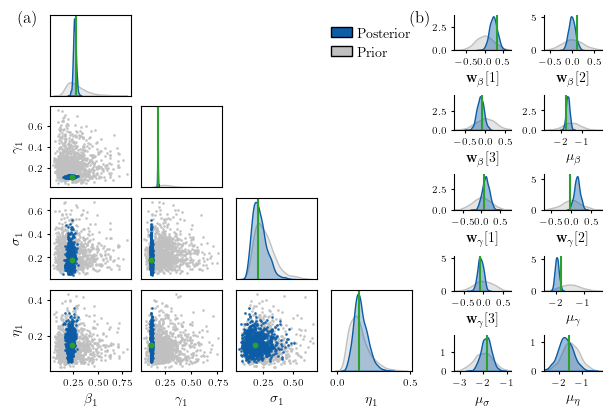

In [12]:
file = "SoftCVI(a=0.75)_seed=1_num_rounds=4_budget=20000"
total_fig = plt.figure(figsize=(6, 4), constrained_layout=True)
ind_fig, pop_fig = total_fig.subfigures(ncols=2, width_ratios=[7, 3])
ind_fig.suptitle("(a)", x=0.03, y=1, ha='left', va='top', fontsize=12)
pop_fig.suptitle("(b)", x=-0.1, y=1, ha='left', va='top', fontsize=12)

samples = {
    "Prior": dict(jnp.load(f"results/samples/joint_{file}.npz")),
    "Posterior": dict(jnp.load(f"results/samples/guide_{file}.npz")),
    "True": dict(jnp.load(f"results/samples/true_{file}.npz")),
}
samples["Prior"] = {k: v for k, v in samples["Prior"].items() if k != "x"}

obs_idx = 1

ind_fig, pairplot_axes = pairplot_dictionary(
    ind_fig,
    {
        "Prior": samples["Prior"]["z"][:, obs_idx],
        "SoftCVI(a=0.75)": samples["Posterior"]["z"][:, obs_idx],
    },
    truth=samples["True"]["z"][obs_idx],
    column_names=[
        r"$\beta_1$",
        r"$\gamma_1$",
        r"$\sigma_1$",
        r"$\eta_1$",
    ],
    s=1,
    palette={
        "Prior": "silver",
        "SoftCVI(a=0.75)": palette["SoftCVI(a=0.75)"],
        "True": "tab:green",
    },
)

# Plot pop marginals:
plot_names = {
    "infection_rate_weights": r"$\mathbf{w}_\beta$",
    "infection_rate_bias": r"$\mu_\beta$",
    "recovery_rate_weights": r"$\mathbf{w}_\gamma$",
    "recovery_rate_bias": r"$\mu_\gamma$",
    "r0_volatility_mean": r"$\mu_\sigma$",
    "r0_mean_reversion_mean": r"$\mu_\eta$",
}

global_parameters = list(plot_names.keys())
global_param_dim = 10

axes = pop_fig.subplots(ncols=2, nrows=global_param_dim // 2)
pop_plot_palette = {
    "Posterior": palette["SoftCVI(a=0.75)"],
    "Prior": "silver",
}
axes = axes.ravel()

idx = 0
for param in global_parameters:
    prior_samps = samples["Prior"][param]
    posterior_samps = samples["Posterior"][param]
    true_samp = samples["True"][param]

    if prior_samps.ndim == 2:
        for col_idx, (prior_col, posterior_col, true) in enumerate(zip(
            prior_samps.T,
            posterior_samps.T,
            true_samp,
            strict=True,
        )):
            sns.kdeplot(prior_col, ax=axes[idx], fill=True, alpha=0.4, color=pop_plot_palette["Prior"])
            sns.kdeplot(posterior_col, ax=axes[idx], fill=True, alpha=0.4, color=pop_plot_palette["Posterior"])
            axes[idx].axvline(true, color="tab:green")
            axes[idx].set_xlabel(plot_names[param] + f"[{col_idx+1}]")
            axes[idx].set_xlim(*jnp.quantile(prior_col, jnp.array([0.001, 0.999])))
            idx += 1
    else:
        sns.kdeplot(prior_samps, ax=axes[idx], fill=True, alpha=0.4, color=pop_plot_palette["Prior"])
        sns.kdeplot(posterior_samps, ax=axes[idx], fill=True, alpha=0.4, color=pop_plot_palette["Posterior"])
        axes[idx].axvline(true_samp, color="tab:green")
        axes[idx].set_xlabel(plot_names[param])
        axes[idx].set_xlim(*jnp.quantile(prior_samps, jnp.array([0.001, 0.999])))
        idx += 1

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

[ax.set_ylabel("") for ax in axes]

handles = [
    mpatches.Patch(facecolor=v, label=k.replace("a=", r"$\\alpha$="), edgecolor="black")
    for k, v in pop_plot_palette.items()
]

pairplot_axes[0, 3].legend(handles=handles, ncols=1, loc="upper center")
total_fig.savefig("plots/sir_covariates_example.pdf", dpi=400)
